## Runtime Environment

* python >= 3.7
* pytorch >= 1.0
* pandas
* nltk
* numpy
* sklearn
* pickle
* tqdm
* json

In [1]:
import pandas as pd

dataset = pd.read_csv('../data/task2_trainset.csv', dtype=str)
dataset.head()

,Id,Title,Abstract,Authors,Categories,Created Date,Task 2
0,D00001,A Brain-Inspired Trust Management Model to Ass...,Rapid popularity of Internet of Things (IoT) a...,Mahmud/Kaiser/Rahman/Rahman/Shabut/Al-Mamun/Hu...,cs.CR/cs.AI/q-bio.NC,2018-01-11,THEORETICAL
1,D00002,On Efficient Computation of Shortest Dubins Pa...,"In this paper, we address the problem of compu...",Sadeghi/Smith,cs.SY/cs.RO/math.OC,2016-09-21,THEORETICAL
2,D00003,Data-driven Upsampling of Point Clouds,High quality upsampling of sparse 3D point clo...,Zhang/Jiang/Yang/Yamakawa/Shimada/Kara,cs.CV,2018-07-07,ENGINEERING
3,D00004,Accessibility or Usability of InteractSE? A He...,Internet is the main source of information now...,Aqle/Khowaja/Al-Thani,cs.HC,2018-08-29,EMPIRICAL
4,D00005,Spatio-Temporal Facial Expression Recognition ...,Automated Facial Expression Recognition (FER) ...,Hasani/Mahoor,cs.CV,2017-03-20,ENGINEERING


In [2]:
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)

In [3]:
dataset.head()

,Id,Abstract,Task 2
0,D00001,Rapid popularity of Internet of Things (IoT) a...,THEORETICAL
1,D00002,"In this paper, we address the problem of compu...",THEORETICAL
2,D00003,High quality upsampling of sparse 3D point clo...,ENGINEERING
3,D00004,Internet is the main source of information now...,EMPIRICAL
4,D00005,Automated Facial Expression Recognition (FER) ...,ENGINEERING


In [5]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

trainset, validset = train_test_split(dataset, test_size=0.1, random_state=42)

trainset.to_csv('trainset.csv', index=False)
validset.to_csv('validset.csv', index=False)

### For test data

In [6]:
dataset = pd.read_csv('../data/task2_public_testset.csv', dtype=str)
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)
dataset.to_csv('testset.csv',index=False)

### 資料格式化 (Data formatting)  
有了字典後，接下來我們要把資料整理成一筆一筆，把input的句子轉成數字，把答案轉成onehot的形式。  
這裡，我們一樣使用`multiprocessing`來加入進行。  
After building dictionary, that's mapping our sentences into number array, and convert answers to onehot format.  

In [67]:
from tqdm import tqdm_notebook as tqdm

def label_to_onehot(labels):
    """ Convert label to onehot .
        Args:
            labels (string): sentence's labels.
        Return:
            outputs (onehot list): sentence's onehot label.
    """
    label_dict = {'THEORETICAL': 0, 'ENGINEERING':1, 'EMPIRICAL':2, 'OTHERS':3}
    onehot = [0,0,0,0]
    for l in labels.split():
        onehot[label_dict[l]] = 1
    return onehot
        
def sentence_to_indices(sentence, word_tokenize):
    """ Convert sentence to its word indices.
    Args:
        sentence (str): One string.
    Return:
        indices (list of int): List of word indices.
    """
    return [word for word in word_tokenize(sentence)]
    
def get_dataset(data_path, word_dict, n_workers=4):
    """ Load data and return dataset for training and validating.

    Args:
        data_path (str): Path to the data.
    """
    dataset = pd.read_csv(data_path, dtype=str)

    results = [None] * n_workers
    with Pool(processes=n_workers) as pool:
        for i in range(n_workers):
            batch_start = (len(dataset) // n_workers) * i
            if i == n_workers - 1:
                batch_end = len(dataset)
            else:
                batch_end = (len(dataset) // n_workers) * (i + 1)
            
            batch = dataset[batch_start: batch_end]
            results[i] = pool.apply_async(preprocess_samples, args=(batch, word_tokenize))

        pool.close()
        pool.join()

    processed = []
    for result in results:
        processed += result.get()
    return processed

def preprocess_samples(dataset, word_dict):
    """ Worker function.

    Args:
        dataset (list of dict)
    Returns:
        list of processed dict.
    """
    processed = []
    for sample in tqdm(dataset.iterrows(), total=len(dataset)):
        processed.append(preprocess_sample(sample[1], word_tokenize))

    return processed

def preprocess_sample(data, word_tokenize):
    """
    Args:
        data (dict)
    Returns:
        dict
    """
    processed = {}
    processed['Abstract'] = [sentence_to_indices(sent, word_tokenize) for sent in data['Abstract'].split('$$$')]
    if 'Task 2' in data:
        processed['Label'] = label_to_onehot(data['Task 2'])
        
    return processed

In [68]:
print('[INFO] Start processing trainset...')
train = get_dataset('trainset.csv', word_tokenize, n_workers=4)
print('[INFO] Start processing validset...')
valid = get_dataset('validset.csv', word_tokenize, n_workers=4)
print('[INFO] Start processing testset...')
test = get_dataset('testset.csv', word_tokenize, n_workers=4)

[INFO] Start processing trainset...




[INFO] Start processing validset...




[INFO] Start processing testset...






In [81]:
def sents2abstract(sents):
    return sum(sents, [])

def create_abstract(dataset):
    abstracts = []
    for data in dataset:
        abstracts.append(sents2abstract(data['Abstract']))
    return abstracts

In [84]:
trainAbstracts = create_abstract(train)
validAbstracts = create_abstract(valid)
testAbstracts = create_abstract(test)

abstracts = trainAbstracts + validAbstracts + testAbstracts

In [85]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(abstracts)]

len(documents)

model = Doc2Vec(documents, vector_size=300, window=5, min_count=3, negative = 10, ns_exponent = -0.5 , workers=4, epochs = 20)

In [115]:
train_docVec = model.docvecs.vectors_docs[:7000]

In [116]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, copy=False, whiten=True, svd_solver='full', random_state=42).fit_transform(train_docVec)

In [151]:
train_pca = pca[:6300]

In [150]:
def label2color(label):
    num = label[0] + 2 * label[1] + 4 * label[2] + 8 * label[3]
    color_dict = {
        1 : "red",
        2 : "orange",
        3 : "yellow",
        4 : "green",
        5 : "blue",
        6 : "purple",
        7 : "pink",
        8 : "black"
    }
    return color_dict[num]

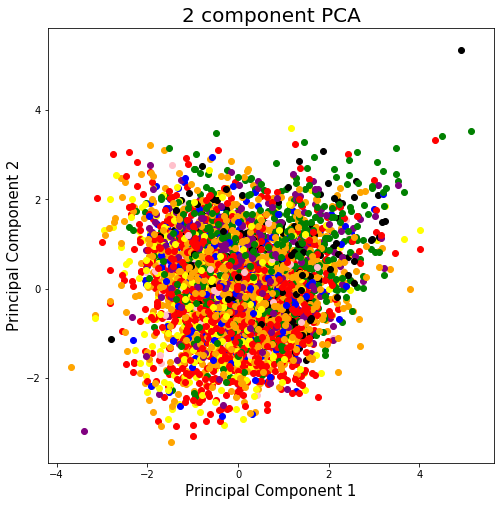

In [152]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
for idx, vec in enumerate(train_pca):
    color = label2color(train[idx]['Label'])
    x = vec[0]
    y = vec[1]
    ax.scatter(x,y,c = color)